In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image

import tensorflow as tf
import seaborn as sns

from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, MaxPooling2D
from tensorflow.keras.applications import DenseNet121,MobileNetV2,vgg19
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomZoom, Rescaling
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization,Activation
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model,save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2, DenseNet121
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split


from collections import Counter
import joblib
from skimage.io import imread
from skimage.transform import resize


np.random.seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


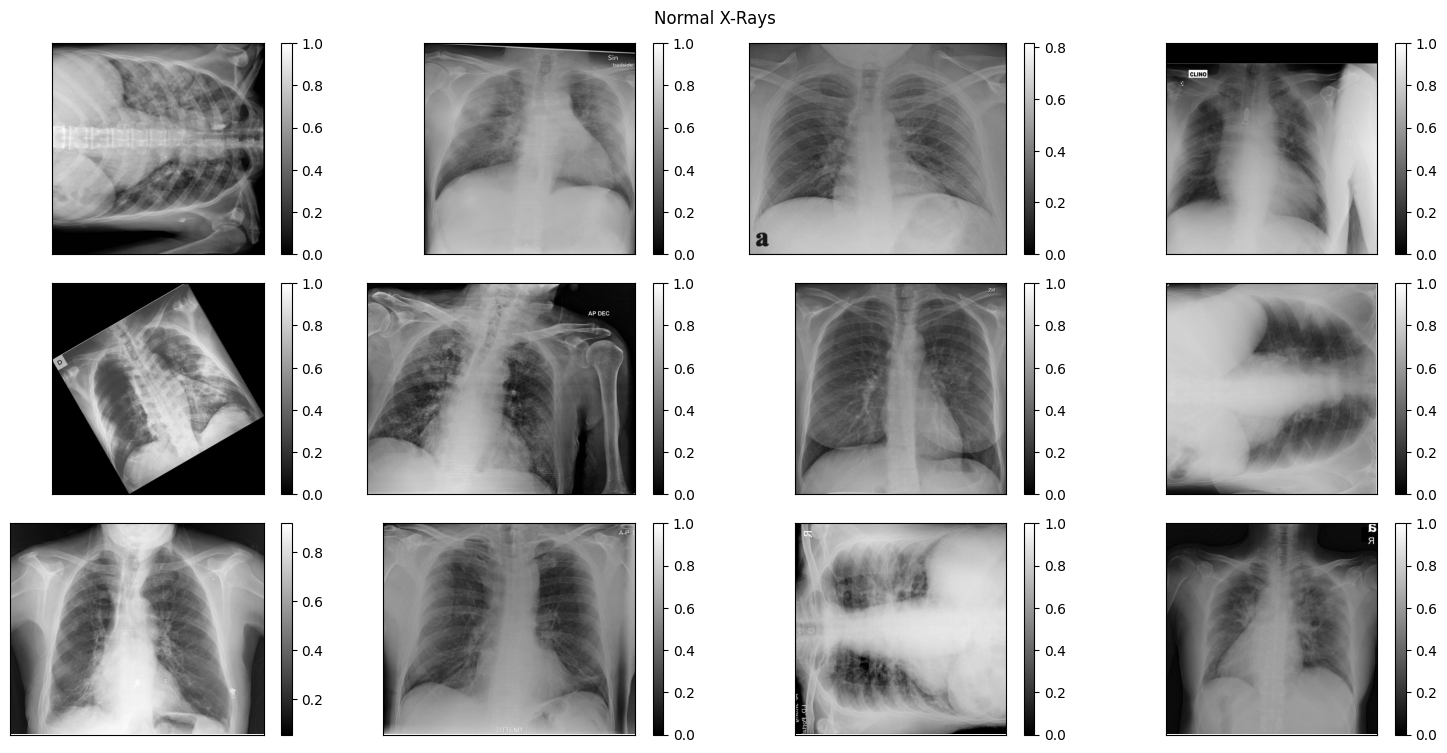

check shape of an example image:  (1024, 1024)


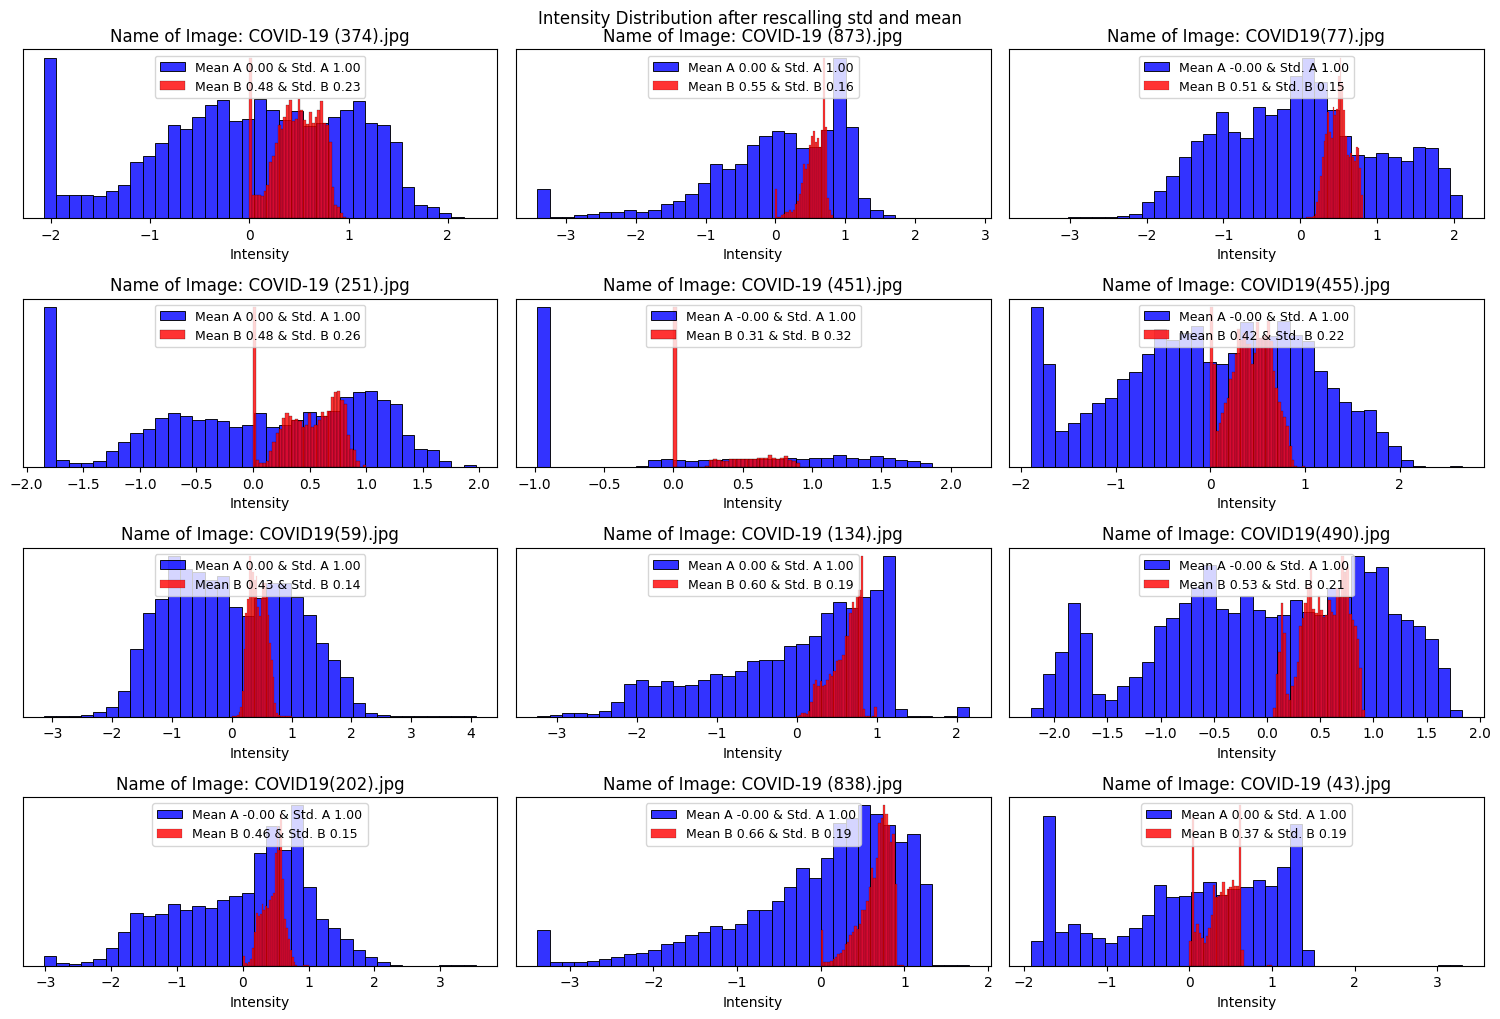

In [ ]:
root_train = '/content/drive/MyDrive/dataset/data/'
labels = ['covid', 'normal','pneumonia']

def check_ims_in_folder(labels):
    #returns tuples of images in each folder
    train_ims_normal = os.listdir(root_train+labels[0]+'/')
    train_ims_pneumonia = os.listdir(root_train+labels[1]+'/')
    train_ims_covid = os.listdir(root_train+labels[2]+'/')

    return (train_ims_normal, train_ims_pneumonia,train_ims_covid)

(train_im_n, train_im_p, train_im_c) = check_ims_in_folder(labels)
def check_im_size(folder, labels):
    im_shape_x_lists_n = []
    im_shape_x_lists_p = []
    im_shape_x_lists_c = []
    im_shape_y_lists_n = []
    im_shape_y_lists_p = []
    im_shape_y_lists_c = []


    path = root_train
    normal = train_im_n
    pneumonia = train_im_p
    covid = train_im_c

    for i, img in enumerate(normal):
        sample = os.path.join(path+labels[0]+'/', img)
        sample_img = Image.open(sample)
        w, h = sample_img.size
        im_shape_x_lists_n.append(w)
        im_shape_y_lists_n.append(h)
    for i, img in enumerate(pneumonia):
        sample = os.path.join(path+labels[1]+'/', img)
        sample_img = Image.open(sample)
        w, h = sample_img.size
        im_shape_x_lists_p.append(w)
        im_shape_y_lists_p.append(h)
    for i, img in enumerate(covid):
        sample = os.path.join(path+labels[2]+'/', img)
        sample_img = Image.open(sample)
        w, h = sample_img.size
        im_shape_x_lists_c.append(w)
        im_shape_y_lists_c.append(h)

    return im_shape_x_lists_n, im_shape_y_lists_n, im_shape_x_lists_p, im_shape_y_lists_p,im_shape_x_lists_c,im_shape_y_lists_c
im_shape_train_x_n, im_shape_train_y_n, im_shape_train_x_p, im_shape_train_y_p,im_shape_train_x_c,im_shape_train_y_c = check_im_size('train', labels)





import os, time, random
fig = plt.figure(figsize=(15, 10))
npics= 12

count = 1
train_im_n_selected = random.sample(train_im_n, 12)
for i, img in enumerate(train_im_n_selected):
    sample = os.path.join(root_train +labels[0]+'/', img)
    sample_img = Image.open(sample)
    sample_img = np.array(sample_img)
    sample_img = sample_img/255.0
    ax = fig.add_subplot(int(npics/3) , 4, count, xticks=[],yticks=[])
    plt.imshow(sample_img, cmap='gray')
    plt.colorbar()
    count +=1
fig.suptitle('Normal X-Rays')
plt.tight_layout()
plt.show()

print ('check shape of an example image: ', sample_img.shape,)

fig = plt.figure(figsize=(15, 15))
count=1
for i, img in enumerate(train_im_n_selected):
    sample_one = os.path.join(root_train +labels[0]+'/', img)
    sample_img = Image.open(sample_one)
    sample_img = np.array(sample_img)
    sample_img = sample_img/255.0
    sample_img_mean = np.mean(sample_img)
    sample_img_std = np.std(sample_img)
    new_sample_img = (sample_img - sample_img_mean)/sample_img_std #standardization formula
    ax = fig.add_subplot(int(npics/2) , 3, count, yticks=[])
    sns.histplot(new_sample_img.ravel(),
             label=f'Mean A {np.mean(new_sample_img):.2f} & Std. A {np.std(new_sample_img):.2f}', kde=False, color='blue', bins=35, alpha=0.8)
    sns.histplot(sample_img.ravel(),
             label=f'Mean B {np.mean(sample_img):.2f} & Std. B {np.std(sample_img):.2f}', kde=False, color='red', bins=35, alpha=0.8)
    plt.legend(loc='upper center', fontsize=9)
    plt.title('Name of Image: %s'% (img))
    plt.xlabel('Intensity')
    plt.ylabel('# Pixels in Image')
    count +=1
fig.suptitle('Intensity Distribution after rescalling std and mean')
plt.tight_layout()
plt.savefig("distribution.png")
plt.show()

In [ ]:
"""
import joblib
from skimage.io import imread
from skimage.transform import resize

def preparing_data(src, pklname, width, height=None):


    height = 256
    data = dict()
    data['description'] = 'resized ({0}x{1})cell images in grayscale'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []

    pklname = f"/content/drive/MyDrive/dataset/data/{pklname}_{width}x{height}px.pkl"


    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        print(subdir)
        current_path = os.path.join(src, subdir)

        for file in os.listdir(current_path):
             if file[-4:] in {'.jpg', '.png','jpeg'}:
                im = imread(os.path.join(current_path, file), as_gray=True)
                im = resize(im, (width, height)) #[:,:,::-1]
                # sample_img = np.array(im)
                # sample_img = sample_img/255.0
                # sample_img_mean = np.mean(sample_img)
                # sample_img_std = np.std(sample_img)
                # new_sample_img = (sample_img - sample_img_mean)/sample_img_std #standardization formula

                data['label'].append(subdir)
                data['filename'].append(file)
                data['data'].append(im)

    joblib.dump(data, pklname)



#
data = '/content/drive/MyDrive/dataset/data/'
preparing_data(src=data, width=256, pklname='covid19')

"""

In [ ]:
# Dataset Preparation

def train_data():
  width=256

  data = joblib.load(f'/content/drive/MyDrive/dataset/data/{"covid19"}_{width}x{width}px.pkl')

  print('Total number of samples: ', len(data['data']))
  print('keys: ', list(data.keys()))
  print('description: ', data['description'])
  print('image shape: ', data['data'][0].shape)
  print('labels:', np.unique(data['label']))

  Counter(data['label'])


  X = np.array(data['data'])
  y = np.array(data['label'])

  y_list = np.unique(y, return_inverse=True)[1].tolist()

  y_labels = []
  for label in y_list:
      if label == 0:
          y_labels.append([1, 0, 0])
      elif label == 1:
          y_labels.append([0, 1, 0])
      else:
          y_labels.append([0, 0, 1])


  y = np.array(y_labels)
  X = X.astype('float32') / 255.


  X = X.reshape(len(X), 256, 256, 1)
  # Apply mean normalization to the image data
  mean = np.mean(X)
  std = np.std(X)
  X = (X - mean) / std

  X_t, X_Test, y_t, y_Test = train_test_split( X, y, test_size=0.2, shuffle=True, random_state=42)
  X_train, X_valid,y_train,y_valid= train_test_split(X_t, y_t, test_size=0.2, shuffle=True, random_state=42 )


  return X_train, y_train , X_Test, y_Test , X_valid, y_valid

X_train, y_train , X_Test, y_Test , X_valid, y_valid = train_data()

Total number of samples:  4575
keys:  ['description', 'label', 'filename', 'data']
description:  resized (256x256)cell images in grayscale
image shape:  (256, 256)
labels: ['covid' 'normal' 'pneumonia']


In [ ]:
print(len(X_train), len(X_Test), len(X_valid))

2928 915 732


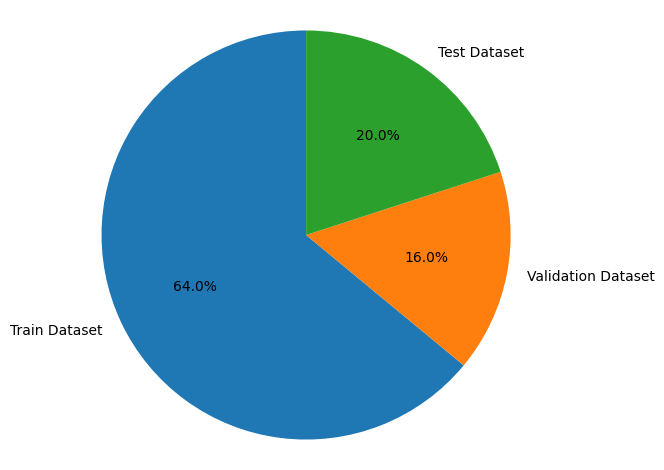

In [ ]:
import matplotlib.pyplot as plt

# Data


labels = ['Train Dataset', 'Validation Dataset', 'Test Dataset']
sizes = [len(X_train), len(X_valid), len(X_Test)]

# Plot
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')

plt.tight_layout()
plt.show()

In [ ]:
X_Test = np.reshape(X_Test, (len(X_Test), 256, 256, 1))

#Functions

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools


np.random.seed(42)
# Create an instance of ImageDataGenerator with augmentation parameters
data_generator = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    )

# Generate augmented data using the ImageDataGenerator
augmented_images = data_generator.flow(X_train, y_train, batch_size=32, seed=42)



data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip(),
  layers.experimental.preprocessing.RandomRotation(10),
  layers.experimental.preprocessing.RandomZoom(0.1)
])


def standardize_layer(tensor):
    tensor_mean = tf.math.reduce_mean(tensor)
    tensor_std = tf.math.reduce_std(tensor)
    new_tensor = (tensor-tensor_mean)/tensor_std
    return new_tensor


METRICS = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

def accuracy(model):
  results = model.evaluate(X_Test, y_Test, batch_size=128)
  print("loss, Accuracy on Test data:", results)

  predictions=model.predict(x=X_Test,verbose=0)
  predictions = np.argmax(predictions, axis=-1)
  return predictions





def plotting(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  precision = history.history['precision']
  val_precision = history.history['val_precision']
  recall = history.history['recall']
  val_recall = history.history['val_recall']


  epochs = range(1, len(acc) + 1)

  fig = plt.figure(figsize=(12, 7))
  fig.add_subplot(221)

  plt.plot(epochs, acc, linestyle='--', label = "Training acc")
  plt.plot(epochs, val_acc, linestyle='-.', label = "Validation acc")
  plt.title("Training and validation acc")
  plt.legend()

  fig.add_subplot(222)
  plt.plot(epochs, loss, linestyle='--', label = "Training loss", alpha=0.8)
  plt.plot(epochs, val_loss, linestyle='-.', label = "Validation loss", alpha=0.6)
  plt.title("Training and validation loss")
  plt.legend()

  fig.add_subplot(223)
  plt.plot(epochs, precision, linestyle='--', label = "Training Precision", alpha=0.8)
  plt.plot(epochs, val_precision, linestyle='-.', label = "Validation Precision", alpha=0.6)
  plt.title("Training and validation Precision")

  fig.add_subplot(224)
  plt.plot(epochs, recall, linestyle='--', label = "Training Recall", alpha=0.8)
  plt.plot(epochs, val_recall, linestyle='-.', label = "Validation Recall", alpha=0.6)
  plt.title("Training and validation Recall")

  plt.show()




rounded_labels=np.argmax(y_Test,axis=-1)
y_true = np.array(rounded_labels)

def plot_confusion_matrix(predictions ,normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    classes=['Covid','Normal','Pneumonia']

    y_pred = np.array(predictions)
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks,classes)

    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # print(cm)

    thresh =cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j]>thresh else "black")
    plt.tight_layout()
    plt.ylabel('Truth label')
    plt.xlabel('Predicted label')



reduce_lr = ReduceLROnPlateau(monitor='val_loss',  factor=0.2, patience=3, min_lr=1e-8, verbose=1)
## added after saving the best model  via val loss gives worse performance than the final step of the model
mcp_save = ModelCheckpoint(filepath="best_model_weights_dense.h5",
                           save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')
##restore best weights added after 2nd training
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
model = Sequential()

model.add(InputLayer(input_shape=(256, 256, 1)))
# 1st conv block
model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001))


# 2nd conv block
model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001))

# ANN block
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=50, activation='relu'))

model.add(Dropout(0.25))
# output layer
model.add(Dense(units=3, activation='softmax'))

# compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=METRICS)
history_model1 = model.fit(x=X_train, y=y_train, batch_size=32,
                    epochs=12, verbose=2,
                    validation_data=(X_valid,y_valid))

Epoch 1/12
92/92 - 20s - loss: 0.5568 - accuracy: 0.7958 - precision: 0.8146 - recall: 0.7698 - prc: 0.8787 - val_loss: 0.8453 - val_accuracy: 0.5396 - val_precision: 0.8506 - val_recall: 0.3579 - val_prc: 0.6971 - 20s/epoch - 216ms/step
Epoch 2/12
92/92 - 4s - loss: 0.2979 - accuracy: 0.9061 - precision: 0.9138 - recall: 0.8941 - prc: 0.9581 - val_loss: 0.7970 - val_accuracy: 0.5219 - val_precision: 0.7635 - val_recall: 0.4057 - val_prc: 0.6969 - 4s/epoch - 41ms/step
Epoch 3/12
92/92 - 3s - loss: 0.2134 - accuracy: 0.9249 - precision: 0.9336 - recall: 0.9173 - prc: 0.9766 - val_loss: 0.5856 - val_accuracy: 0.7596 - val_precision: 0.8774 - val_recall: 0.6161 - val_prc: 0.8619 - 3s/epoch - 37ms/step
Epoch 4/12
92/92 - 3s - loss: 0.1559 - accuracy: 0.9450 - precision: 0.9500 - recall: 0.9406 - prc: 0.9868 - val_loss: 0.5093 - val_accuracy: 0.7609 - val_precision: 0.8379 - val_recall: 0.6639 - val_prc: 0.8831 - 3s/epoch - 37ms/step
Epoch 5/12
92/92 - 4s - loss: 0.1466 - accuracy: 0.9515 -

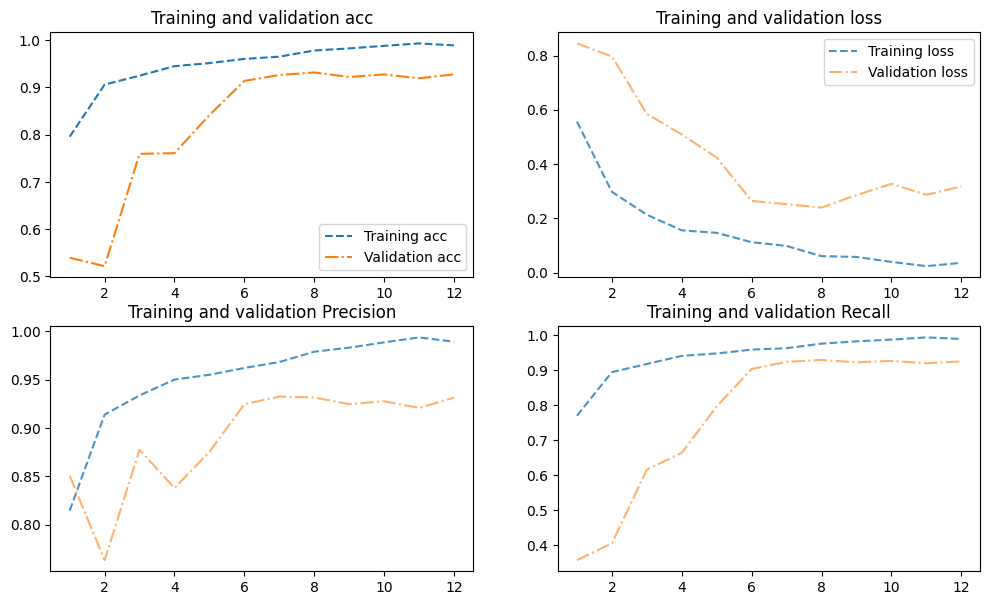


 Accuracy of Model : 
8/8 [==============================] - 1s 59ms/step - loss: 0.3258 - accuracy: 0.9311 - precision: 0.9319 - recall: 0.9279 - prc: 0.9500
loss, Accuracy on Test data: [0.3258325457572937, 0.9311475157737732, 0.9319429397583008, 0.9278688430786133, 0.9499685764312744]
Confusion Matrix
Confusion matrix, without normalization


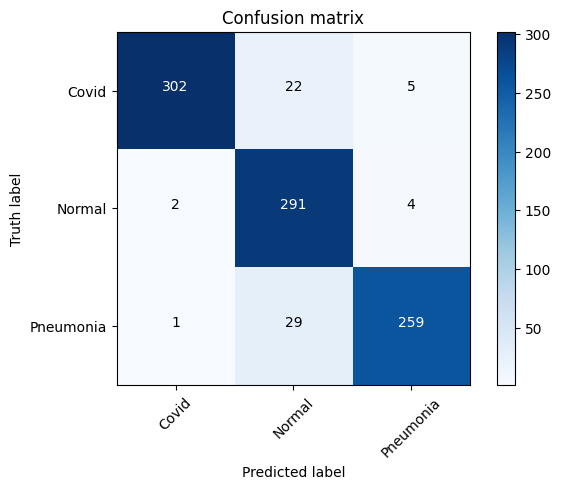

In [ ]:
plotting(history_model1)
print("\n Accuracy of Model : ")
predictions=accuracy(model)
print("Confusion Matrix")
plot_confusion_matrix(predictions,  title='Confusion matrix')

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
model2 = Sequential()

model2.add(InputLayer(input_shape=(256, 256, 1)))
# 1st conv block
model2.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model2.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# 2nd conv block
model2.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model2.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model2.add(BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001))

# ANN block
model2.add(Flatten())
model2.add(Dense(units=50, activation='relu'))
model2.add(Dropout(0.25))
# output layer
model2.add(Dense(units=3, activation='softmax'))

# compile model
model2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=METRICS)

history_model2 = model2.fit(augmented_images, batch_size=32,
                    epochs=12, verbose=2,
                    validation_data=(X_valid,y_valid))

model2.save('/content/drive/MyDrive/dataset/data/model2.h5')

Epoch 1/12
92/92 - 19s - loss: 0.6750 - accuracy: 0.7589 - precision: 0.8286 - recall: 0.7637 - prc: 0.8692 - val_loss: 0.8427 - val_accuracy: 0.7459 - val_precision: 0.8889 - val_recall: 0.2951 - val_prc: 0.8033 - 19s/epoch - 201ms/step
Epoch 2/12
92/92 - 15s - loss: 0.5159 - accuracy: 0.8139 - precision: 0.8446 - recall: 0.7613 - prc: 0.8877 - val_loss: 0.6568 - val_accuracy: 0.8456 - val_precision: 0.9220 - val_recall: 0.5492 - val_prc: 0.9137 - 15s/epoch - 166ms/step
Epoch 3/12
92/92 - 15s - loss: 0.4474 - accuracy: 0.8453 - precision: 0.8678 - recall: 0.8091 - prc: 0.9114 - val_loss: 0.5022 - val_accuracy: 0.8811 - val_precision: 0.9237 - val_recall: 0.7609 - val_prc: 0.9414 - 15s/epoch - 165ms/step
Epoch 4/12
92/92 - 15s - loss: 0.4442 - accuracy: 0.8378 - precision: 0.8642 - recall: 0.7954 - prc: 0.9124 - val_loss: 0.4039 - val_accuracy: 0.9003 - val_precision: 0.9211 - val_recall: 0.8456 - val_prc: 0.9514 - 15s/epoch - 166ms/step
Epoch 5/12
92/92 - 15s - loss: 0.3887 - accuracy

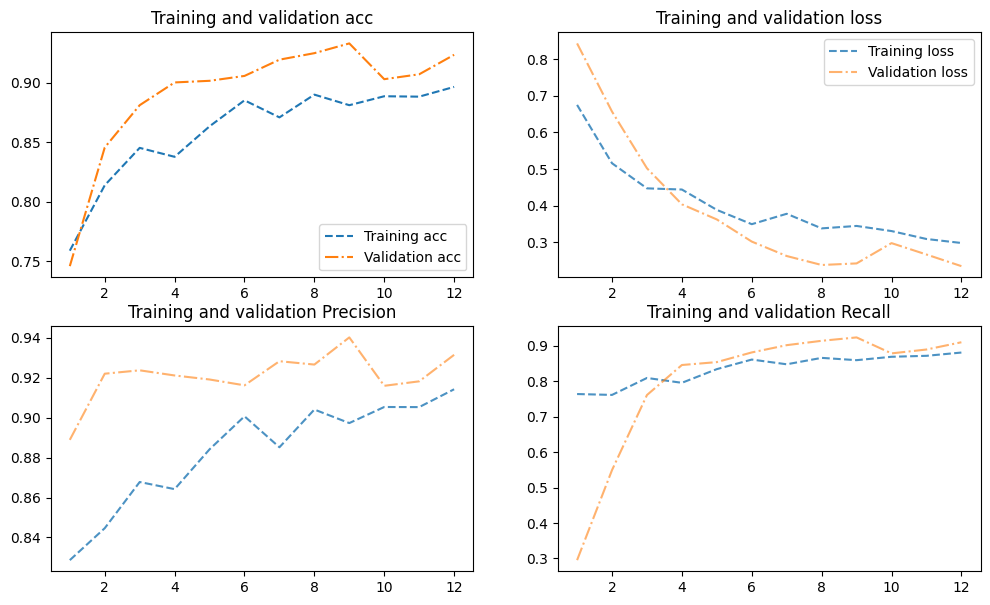


 Accuracy of Model : 
8/8 [==============================] - 0s 42ms/step - loss: 0.2424 - accuracy: 0.9257 - precision: 0.9302 - recall: 0.9180 - prc: 0.9701
loss, Accuracy on Test data: [0.24236442148685455, 0.9256830811500549, 0.930232584476471, 0.9180327653884888, 0.9700868725776672]
Confusion Matrix
Confusion matrix, without normalization


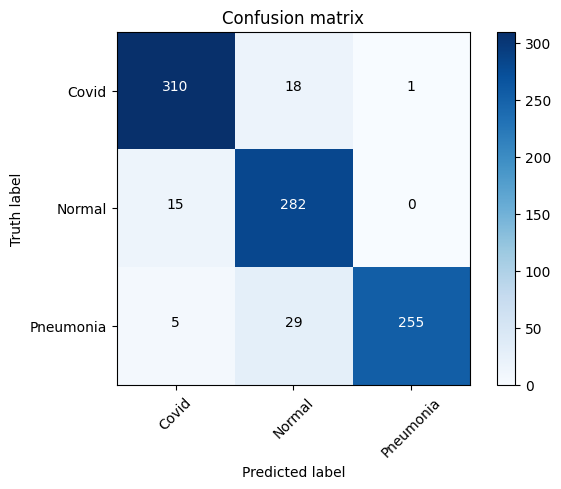

In [ ]:
plotting(history_model2)
print("\n Accuracy of Model : ")
predictions2= accuracy(model2)
print("Confusion Matrix")
plot_confusion_matrix(predictions2,  title='Confusion matrix')

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
model3 = Sequential()

model3.add(InputLayer(input_shape=(256, 256, 1)))


# 1st conv block
model3.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model3.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# 2nd conv block
model3.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model3.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model3.add(BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001))

# 3rd conv block
model3.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model3.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model3.add(BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001))
model3.add(Dropout(0.25))


# ANN block
model3.add(Flatten())
model3.add(Dense(units=100, activation='relu'))
model3.add(Dense(units=100, activation='relu'))
model3.add(Dropout(0.25))
# output layer
model3.add(Dense(units=3, activation='softmax'))

# compile model
model3.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=METRICS)
history_model3 = model3.fit(augmented_images, batch_size=32,
                    epochs=12, verbose=2,
                    validation_data=(X_valid,y_valid))
model3.save('/content/drive/MyDrive/dataset/data/model3.h5')

Epoch 1/12
92/92 - 22s - loss: 0.7780 - accuracy: 0.6814 - precision: 0.7749 - recall: 0.6932 - prc: 0.8294 - val_loss: 0.9753 - val_accuracy: 0.4495 - val_precision: 0.9487 - val_recall: 0.2527 - val_prc: 0.6149 - 22s/epoch - 239ms/step
Epoch 2/12
92/92 - 16s - loss: 0.5704 - accuracy: 0.7872 - precision: 0.8110 - recall: 0.7490 - prc: 0.8619 - val_loss: 0.9754 - val_accuracy: 0.3962 - val_precision: 0.5169 - val_recall: 0.3142 - val_prc: 0.5924 - 16s/epoch - 176ms/step
Epoch 3/12
92/92 - 16s - loss: 0.4897 - accuracy: 0.8265 - precision: 0.8487 - recall: 0.7947 - prc: 0.8956 - val_loss: 0.9838 - val_accuracy: 0.4508 - val_precision: 0.4899 - val_recall: 0.3648 - val_prc: 0.6140 - 16s/epoch - 174ms/step
Epoch 4/12
92/92 - 16s - loss: 0.4647 - accuracy: 0.8265 - precision: 0.8488 - recall: 0.8050 - prc: 0.9040 - val_loss: 0.6368 - val_accuracy: 0.7391 - val_precision: 0.7763 - val_recall: 0.6544 - val_prc: 0.8150 - 16s/epoch - 171ms/step
Epoch 5/12
92/92 - 16s - loss: 0.4329 - accuracy

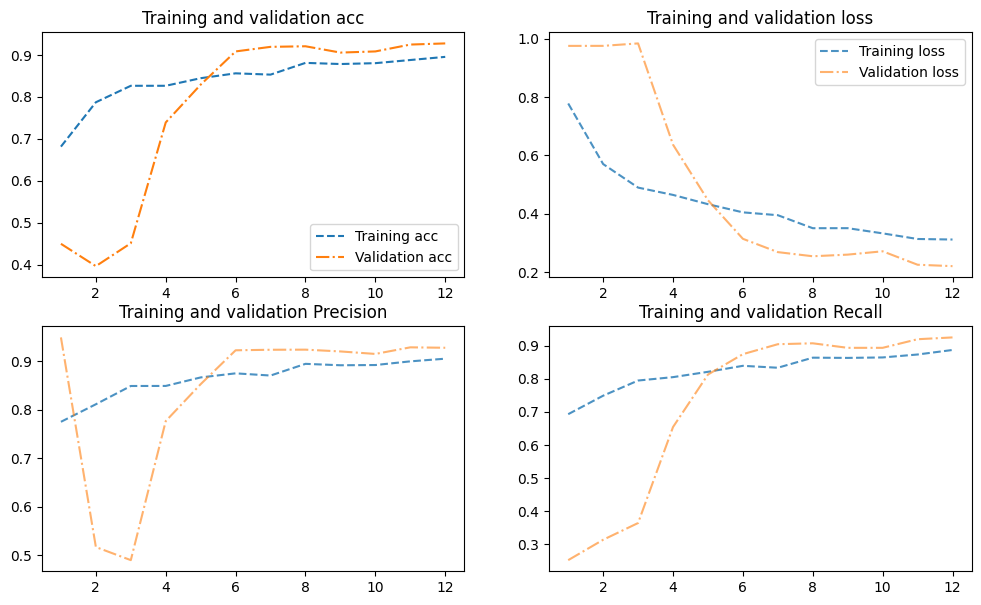


 Accuracy of Model : 
8/8 [==============================] - 0s 39ms/step - loss: 0.2233 - accuracy: 0.9224 - precision: 0.9253 - recall: 0.9202 - prc: 0.9736
loss, Accuracy on Test data: [0.22325555980205536, 0.9224043488502502, 0.9252747297286987, 0.9202185869216919, 0.9736419916152954]
Confusion Matrix
Confusion matrix, without normalization


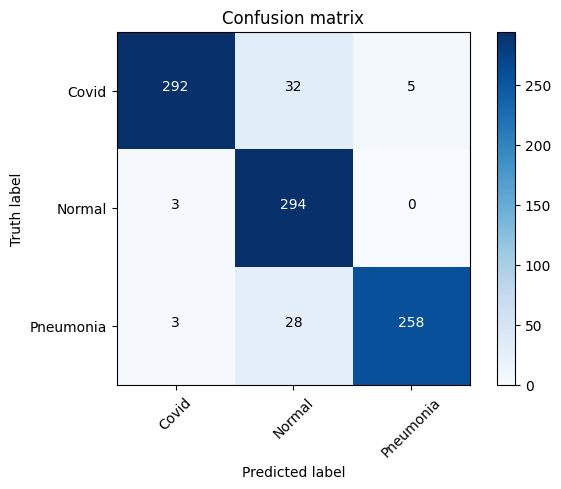

In [ ]:
plotting(history_model3)
print("\n Accuracy of Model : ")
prediction3 = accuracy(model3)
print("Confusion Matrix")
plot_confusion_matrix(prediction3,  title='Confusion matrix')

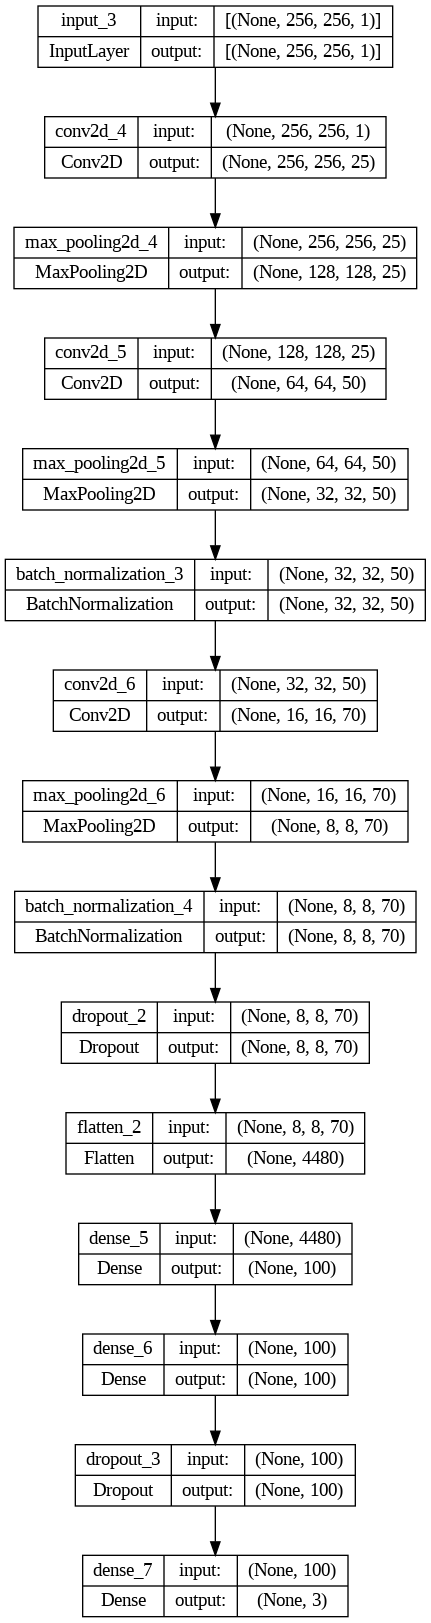

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
model4 = Sequential()

model4.add(InputLayer(input_shape=(256, 256, 1)))


# 1st conv block
model4.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
model4.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model4.add(BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001))


# 2nd conv block
model4.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
model4.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model4.add(BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001))
model4.add(Dropout(0.3))

# 3rd conv block
model4.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model4.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model4.add(BatchNormalization(axis=-1,momentum=0.99, epsilon=0.001))

model4.add(Dropout(0.4))


# ANN block
model4.add(Flatten())
model4.add(Dense(units=100, activation='relu'))
model4.add(Dense(units=150, activation='relu'))
model4.add(Dropout(0.25))
# output layer
model4.add(Dense(units=3, activation='softmax'))

# compile model
model4.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=METRICS)

history_model4 = model4.fit(augmented_images, batch_size=32,
                    epochs=12, verbose=2,
                    validation_data=(X_valid,y_valid))
model4.save('/content/drive/MyDrive/dataset/data/model4.h5')

Epoch 1/12
92/92 - 23s - loss: 0.8349 - accuracy: 0.6513 - precision: 0.7533 - recall: 0.6617 - prc: 0.8063 - val_loss: 1.1787 - val_accuracy: 0.4495 - val_precision: 0.6978 - val_recall: 0.3060 - val_prc: 0.5821 - 23s/epoch - 245ms/step
Epoch 2/12
92/92 - 17s - loss: 0.6121 - accuracy: 0.7661 - precision: 0.7943 - recall: 0.7254 - prc: 0.8438 - val_loss: 1.0603 - val_accuracy: 0.4167 - val_precision: 0.5451 - val_recall: 0.3552 - val_prc: 0.5839 - 17s/epoch - 180ms/step
Epoch 3/12
92/92 - 16s - loss: 0.5563 - accuracy: 0.7927 - precision: 0.8248 - recall: 0.7572 - prc: 0.8701 - val_loss: 0.9283 - val_accuracy: 0.4781 - val_precision: 0.5913 - val_recall: 0.4249 - val_prc: 0.6451 - 16s/epoch - 179ms/step
Epoch 4/12
92/92 - 17s - loss: 0.4847 - accuracy: 0.8214 - precision: 0.8415 - recall: 0.7941 - prc: 0.8989 - val_loss: 0.7457 - val_accuracy: 0.6284 - val_precision: 0.6898 - val_recall: 0.4891 - val_prc: 0.7391 - 17s/epoch - 186ms/step
Epoch 5/12
92/92 - 17s - loss: 0.4601 - accuracy

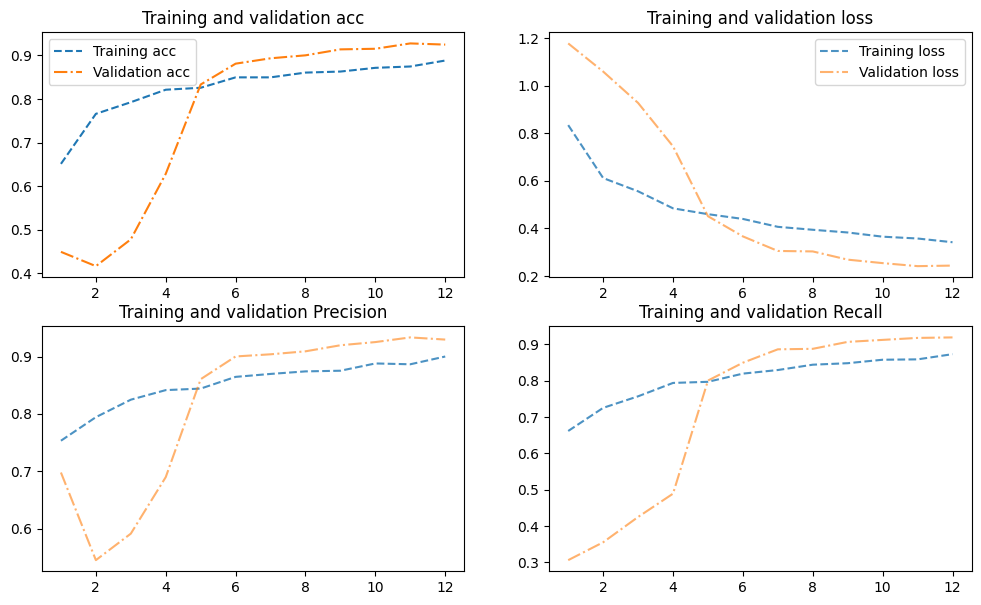


 Accuracy of Model : 
8/8 [==============================] - 0s 47ms/step - loss: 0.2525 - accuracy: 0.9158 - precision: 0.9220 - recall: 0.9049 - prc: 0.9672
loss, Accuracy on Test data: [0.25251343846321106, 0.9158470034599304, 0.9220489859580994, 0.9049180150032043, 0.9672224521636963]
Confusion Matrix
Confusion matrix, without normalization


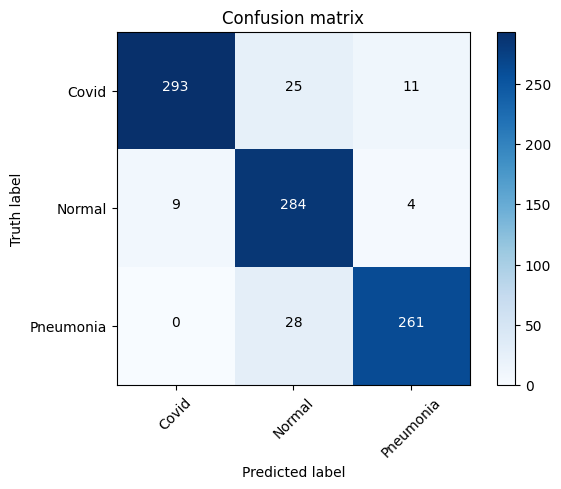

In [ ]:
plotting(history_model4)
print("\n Accuracy of Model : ")
predictions4 = accuracy(model4)
print("Confusion Matrix")
plot_confusion_matrix(predictions4,  title='Confusion matrix')

## Densenet 121


In [ ]:

# Create the base DenseNet-121 model
Dense_model = DenseNet121(include_top=False, weights=None, input_shape=(256, 256, 1))

x = Dense_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # Replace num_classes with the number of classes in your dataset

# Create the final model
dense121 = Model(inputs=Dense_model.input, outputs=predictions)

# Compile the model
dense121.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=METRICS)

# Train the model on your own dataset
dense121_hist = dense121.fit(augmented_images, batch_size=32,
                    epochs=12, verbose=2,
                    validation_data=(X_valid,y_valid))

Epoch 1/12
92/92 - 131s - loss: 0.5380 - accuracy: 0.8026 - precision: 0.8530 - recall: 0.7684 - prc: 0.8960 - val_loss: 1.6234 - val_accuracy: 0.3115 - val_precision: 0.3110 - val_recall: 0.3101 - val_prc: 0.2967 - 131s/epoch - 1s/step
Epoch 2/12
92/92 - 39s - loss: 0.3404 - accuracy: 0.8818 - precision: 0.8968 - recall: 0.8665 - prc: 0.9464 - val_loss: 1.9340 - val_accuracy: 0.3306 - val_precision: 0.3338 - val_recall: 0.2951 - val_prc: 0.3383 - 39s/epoch - 428ms/step
Epoch 3/12
92/92 - 40s - loss: 0.3074 - accuracy: 0.8972 - precision: 0.9079 - recall: 0.8852 - prc: 0.9542 - val_loss: 1.8069 - val_accuracy: 0.3648 - val_precision: 0.3673 - val_recall: 0.3347 - val_prc: 0.3775 - 40s/epoch - 432ms/step
Epoch 4/12
92/92 - 40s - loss: 0.2603 - accuracy: 0.9133 - precision: 0.9226 - recall: 0.9033 - prc: 0.9660 - val_loss: 1.2960 - val_accuracy: 0.5710 - val_precision: 0.5903 - val_recall: 0.5314 - val_prc: 0.5370 - 40s/epoch - 437ms/step
Epoch 5/12
92/92 - 40s - loss: 0.2531 - accuracy:

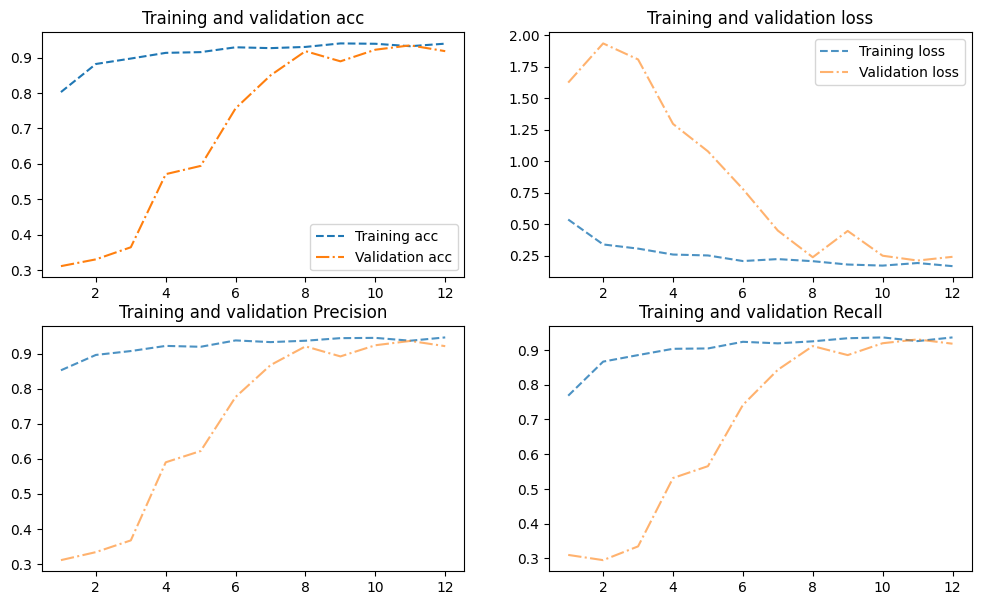

8/8 [==============================] - 11s 642ms/step - loss: 0.2127 - accuracy: 0.9388 - precision: 0.9428 - recall: 0.9366 - prc: 0.9743
loss, Accuracy on Test data: [0.21266864240169525, 0.9387978315353394, 0.9427942633628845, 0.9366120100021362, 0.9743345379829407]


In [ ]:
plotting(dense121_hist)
predictions = accuracy(dense121)

In [ ]:
from tensorflow.keras.applications import ResNet50
# Load the ResNet50 model without pre-trained weights
base_model = ResNet50(weights=None, include_top=False, input_shape=(256, 256, 1))

# Add custom classification layers
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)  # Replace num_classes with the number of classes in your dataset

# Create the model
Resnet = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
Resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

# Train the model on your dataset
Resnet_hist = Resnet.fit(augmented_images, batch_size=32,
                    epochs=12, verbose=2,
                    validation_data=(X_valid,y_valid))

Epoch 1/12
92/92 - 99s - loss: 14.6815 - accuracy: 0.4228 - precision: 0.5975 - recall: 0.4530 - prc: 0.5644 - val_loss: 1.0885 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_prc: 0.4652 - 99s/epoch - 1s/step
Epoch 2/12
92/92 - 40s - loss: 2.3912 - accuracy: 0.5977 - precision: 0.6517 - recall: 0.4843 - prc: 0.5799 - val_loss: 1.1397 - val_accuracy: 0.3443 - val_precision: 0.6550 - val_recall: 0.2801 - val_prc: 0.4858 - 40s/epoch - 439ms/step
Epoch 3/12
92/92 - 39s - loss: 0.9762 - accuracy: 0.7254 - precision: 0.7574 - recall: 0.6547 - prc: 0.7580 - val_loss: 0.9879 - val_accuracy: 0.5068 - val_precision: 0.5892 - val_recall: 0.4781 - val_prc: 0.5976 - 39s/epoch - 421ms/step
Epoch 4/12
92/92 - 41s - loss: 0.6615 - accuracy: 0.7681 - precision: 0.8002 - recall: 0.7128 - prc: 0.8316 - val_loss: 0.6534 - val_accuracy: 0.7418 - val_precision: 0.7709 - val_recall: 0.6803 - val_prc: 0.8021 - 41s/epoch - 450ms/step
Epoch 5/12
92/92 - 42s - loss: 0.6429 - ac

In [ ]:
predictions = accuracy(Resnet)

8/8 [==============================] - 8s 520ms/step - loss: 0.3534 - accuracy: 0.8831 - precision: 0.8969 - recall: 0.8557 - prc: 0.9435
loss, Accuracy on Test data: [0.35337379574775696, 0.883060097694397, 0.8969072103500366, 0.8557376861572266, 0.9434949159622192]


##For Live Demo, Loading saved models and testnig accuracy on test dataset

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 256, 25)      650       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 25)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 50)        31300     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 50)       0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 50)       200       
 hNormalization)                                                 
                                                      

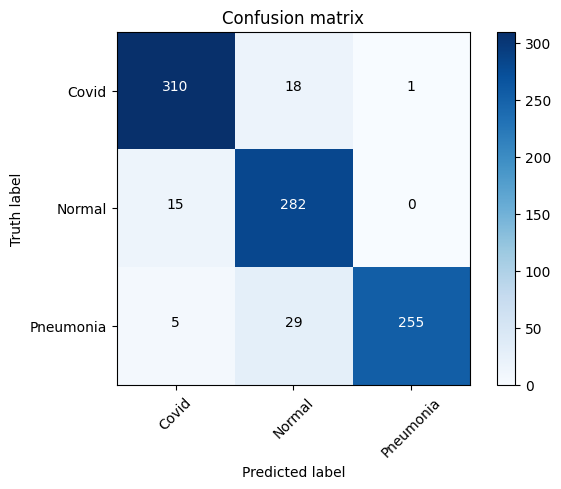

In [ ]:
model1 = tf.keras.models.load_model('/content/drive/MyDrive/dataset/data/model2.h5')
model1.summary()
model1 = accuracy(model1)
plot_confusion_matrix( model1,  title=f'Confusion matrix')


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 25)      650       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 25)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 50)        31300     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 50)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 50)       200       
 hNormalization)                                                 
                                                      

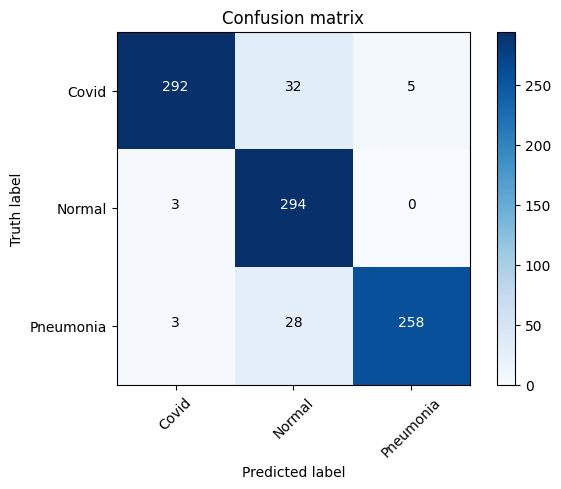

In [ ]:
model2 = tf.keras.models.load_model('/content/drive/MyDrive/dataset/data/model3.h5')
model2.summary()

model2 = accuracy(model2)
plot_confusion_matrix(model2,  title=f'Confusion matrix')


8/8 [==============================] - 1s 48ms/step - loss: 0.2525 - accuracy: 0.9158 - precision: 0.9220 - recall: 0.9049 - prc: 0.9672
loss, Accuracy on Test data: [0.25251343846321106, 0.9158470034599304, 0.9220489859580994, 0.9049180150032043, 0.9672224521636963]
Confusion matrix, without normalization


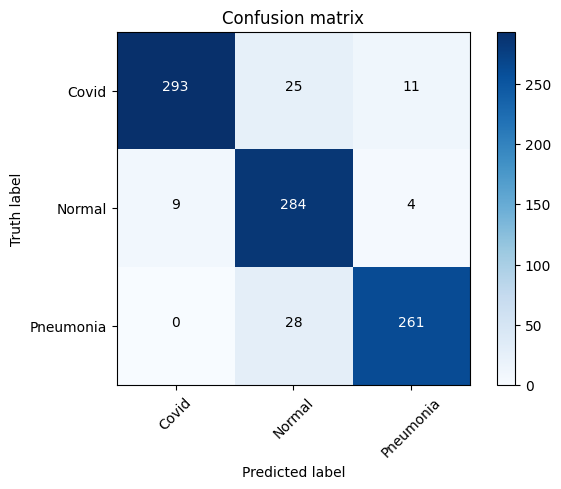

In [ ]:
model3 = tf.keras.models.load_model('/content/drive/MyDrive/dataset/data/model4.h5')
model3 = accuracy(model3)
plot_confusion_matrix(model3,  title=f'Confusion matrix')

In [ ]:
# m1, 9366 , m2 , 9257, m3, 9355, m4 9060, dense 80, res 91

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 25)      650       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 128, 128, 25)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 50)        31300     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 50)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 50)       200       
 hNormalization)                                                 
                                                      

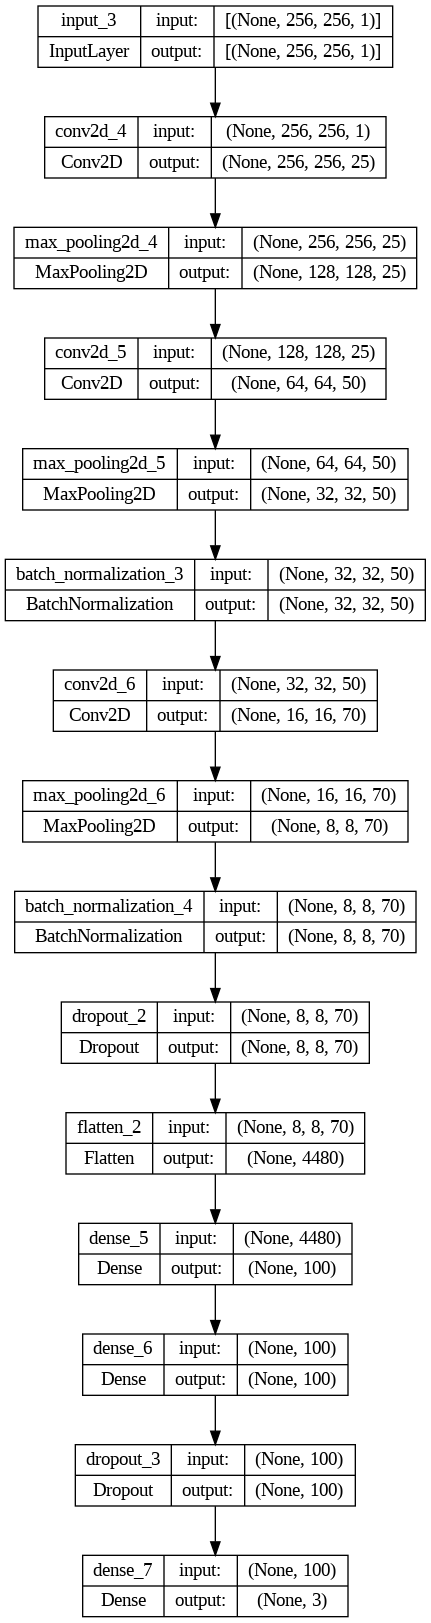

In [3]:
#apply some grid search model to find the best parameters

model2 = tf.keras.models.load_model('/content/drive/MyDrive/dataset/data/model3.h5')
model2.summary()

from keras.utils.vis_utils import plot_model
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)